In [2]:
%cd "./drive/My Drive/Colab Notebooks/neural-learning"

/content/drive/My Drive/Colab Notebooks/neural-learning


In [0]:
!git stash
!git pull
!git stash apply

In [97]:
! git add main.ipynb
! git commit -m "lol"
! git status

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


In [96]:
!git push

Everything up-to-date


In [3]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import copy
import numpy as np
from scipy.signal import find_peaks
import scipy.fftpack
from matplotlib import pyplot as plt
import seaborn as sns

from src.network import Layer
from src.ou_process import ouprocess_gaussian
from src.experiment import Experiment

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
NUM_NEURONS = 200
tau_V = 10
R = 1 # MOhm
EL = -70.0
V_th = -40.0
dt = 0.1 # msec
t_stop = 30.0e3

RESULTS_DIR = "./results"
GRAPHS_DIR = "./graphs"

In [0]:
# Slow Signal: INPUT
input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
i_inj = 16.0 + 6.0*input_slow

In [6]:
layer = Layer(NUM_NEURONS)
layer.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop)
out, V, F_binary, F_synaptic = layer.output(i_inj, dt, t_stop)

/content/drive/My Drive/Colab Notebooks/neural-learning/src/network.py:84: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.W, residuals, rank, s = np.linalg.lstsq(A, exp_output)


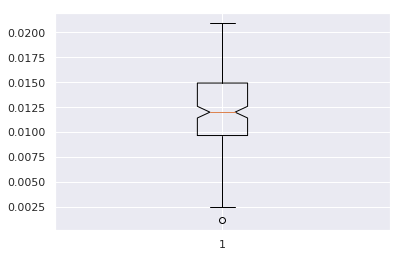

In [7]:
plt.boxplot(layer.W, notch=True, sym="o")
plt.show()

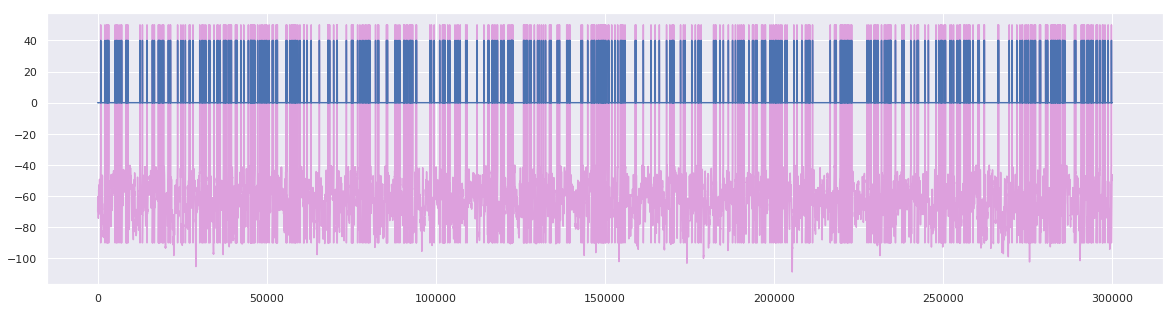

In [8]:
trial = 10
t_i = 0
t_f = -1
plt.figure(figsize=(20,5))
plt.plot(V[t_i:t_f,trial], color='plum')
plt.plot(F_binary[t_i:t_f,trial] * 40.0)
plt.show()

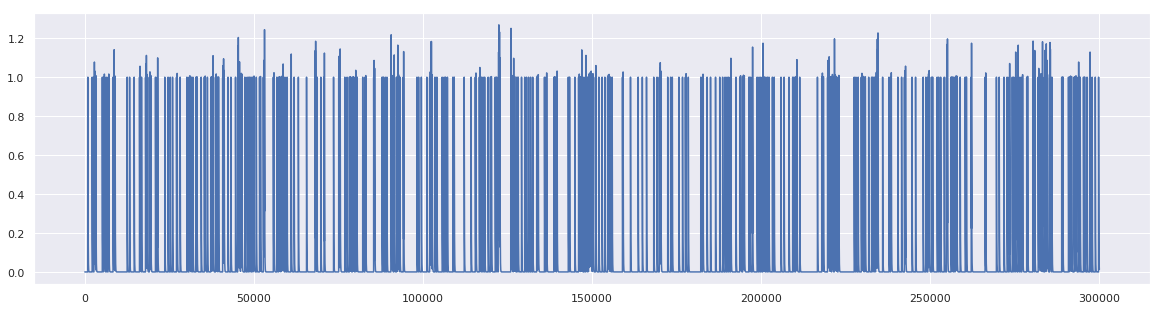

In [9]:
plt.figure(figsize=(20,5))
plt.plot(F_synaptic[:,10])
plt.show()

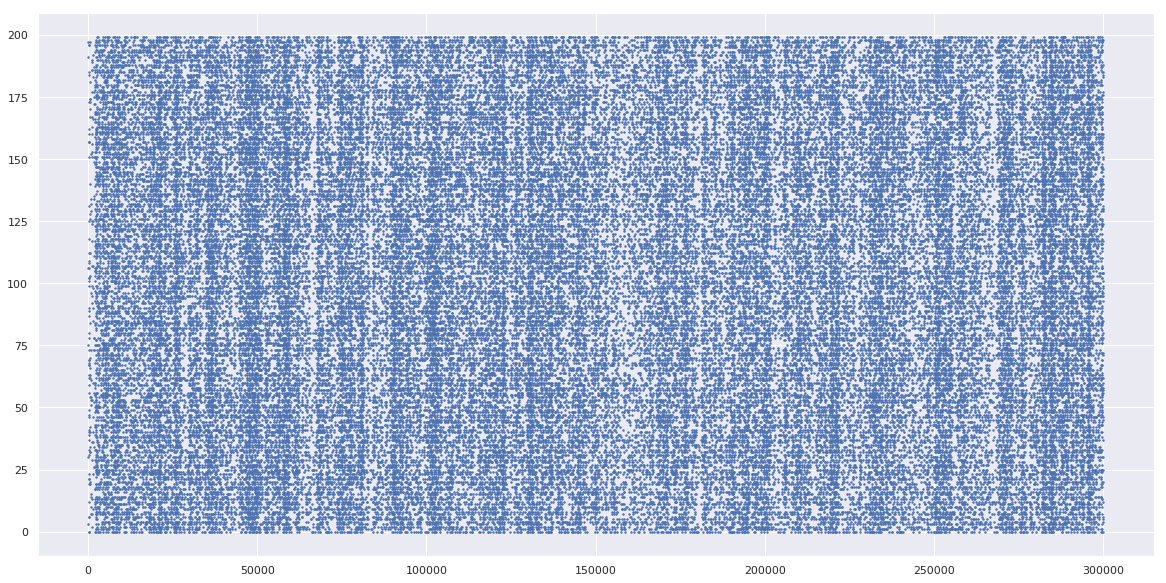

In [10]:
spike_inds, spike_trial = np.where(F_binary > 0)
plt.figure(figsize=(20,10))
plt.scatter(spike_inds, spike_trial, s=2)
plt.show()

In [11]:
a = np.where(F_binary[:,10] > 0)[0]
a.shape

(432,)

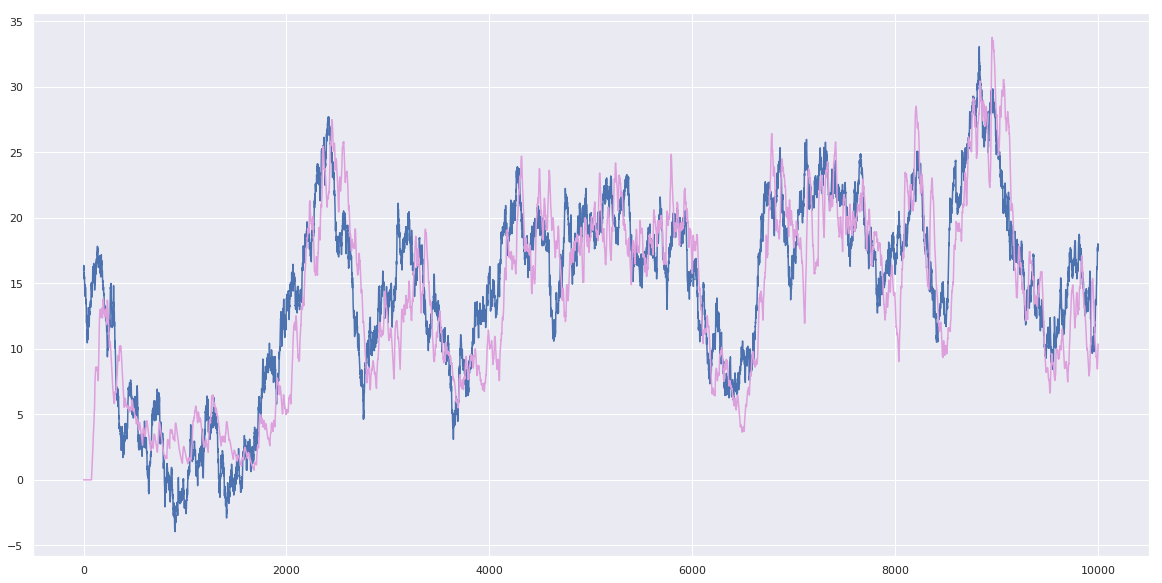

In [12]:
plt.figure(figsize=(20,10))
plt.plot(i_inj[:10000])
plt.plot(out[:10000], 'plum')
plt.show()

In [13]:
np.linalg.norm(out-i_inj)

2107.538623575211

### PoC 1a
For the SAME INPUT, can we shuffle / regenerate internal noise?

In [0]:
LOAD_POC_1A = True
load_poc_1a_file = "poc1a__neurons=200__trials=200__input=tau_50_same__t_stop=5000_msecs"

test_t_stop = 5000.0

if LOAD_POC_1A:
    experiment = Experiment.load(RESULTS_DIR, load_poc_1a_file)
else:
    NUM_TRIALS = 200

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        inputs[:,i] = layer.train_input.flatten()[num_t*2:num_t*3]

    experiment = Experiment(inputs, layer, NUM_TRIALS, dt, test_t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_poc_1a_file)

In [0]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

In [38]:
efficiencies.shape

(200,)

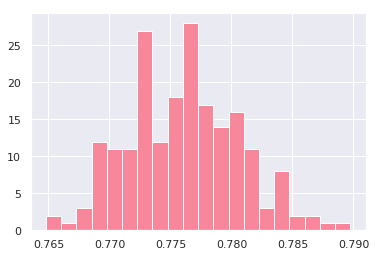

In [39]:
plt.hist(efficiencies, bins=20, color=sns.xkcd_rgb["rose pink"])
plt.show()

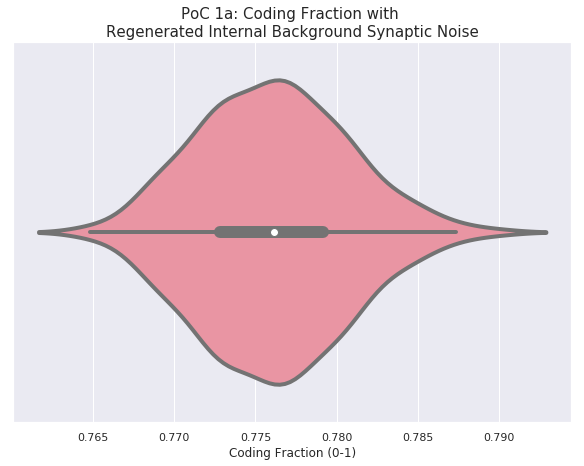

In [46]:
plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('PoC 1a: Coding Fraction with \nRegenerated Internal Background Synaptic Noise', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

# plt.show()
plt.savefig((os.path.join(GRAPHS_DIR, load_poc_1a_file + ".png")))

### PoC 1b
SAME INPUT: Can we approximate weights as N(u, sig)? How does this affect reconstruction?

In [0]:
LOAD_POC_1B = False
load_poc1b_file = "poc1b__neurons=200__trials=200__input=tau_50_same__t_stop=5000_msecs"

In [0]:
test_t_stop = 5000.0

if LOAD_POC_1B:
    experiment = Experiment.load(RESULTS_DIR, load_poc_1B_file)
else:
    NUM_TRIALS = 200

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        inputs[:,i] = layer.train_input.flatten()[num_t*2:num_t*3]

    layer_shuffle = copy.deepcopy(layer)

    mean_weight = np.mean(layer_shuffle.W)
    std_weight = np.std(layer_shuffle.W)

    experiment = Experiment(inputs, layer_shuffle, NUM_TRIALS, dt, test_t_stop)

    for trial in range(NUM_TRIALS):
        experiment.layer.W = np.random.normal(mean_weight, std_weight, experiment.layer.W.shape)
        experiment.one_trial(trial, int_noise_regen=False)
    experiment.save(RESULTS_DIR, load_poc1b_file)

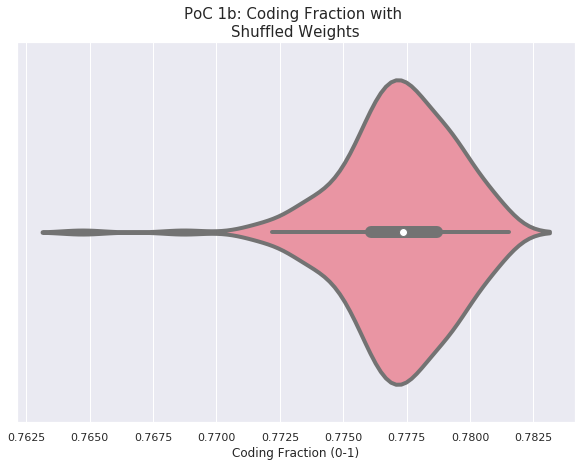

In [51]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('PoC 1b: Coding Fraction with \nShuffled Weights', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

# plt.show()
plt.savefig(os.path.join(GRAPHS_DIR, load_poc1b_file + ".png"))

### PoC 2a
DIFFERENT INPUTS: shuffle internal noise, how does this affect reconstruction?

In [0]:
LOAD_POC_2A = True
load_poc_2a_file = "poc2a__neurons=200__trials=100__input=tau_50_regenerated"

In [0]:
if LOAD_POC_2A:
    experiment = Experiment.load(RESULTS_DIR, load_poc_2a_file)
else:
    NUM_TRIALS = 100

    num_t = np.arange(0.0, t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,i] = i_inj.flatten()

    experiment = Experiment(inputs, layer, NUM_TRIALS, dt, t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_poc_2a_file)

In [0]:
l2_norms = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    l2_norms[i] = np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])

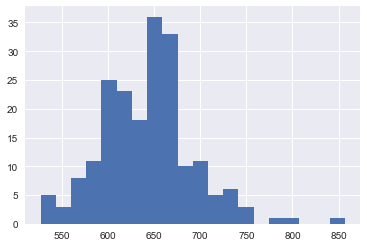

In [0]:
plt.hist(l2_norms, bins=20)
plt.show()

In [0]:
plt.boxplot(l2_norms, notch=True, sym="o")
plt.show()

### PoC 2b
DIFFERENT INPUTS: shuffle weights, how does this affect reconstruction?

In [0]:
LOAD_POC_2B = True
load_poc_2b_file = "poc2b__neurons=200__trials=100__input=tau_50_regenerated"

In [0]:
if LOAD_POC_2B:
    experiment = Experiment.load(RESULTS_DIR, load_poc_2b_file)
else:
    NUM_TRIALS = 100

    num_t = np.arange(0.0, t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,i] = i_inj.flatten()

    layer_shuffle = copy.deepcopy(layer)

    mean_weight = np.mean(layer_shuffle.W)
    std_weight = np.std(layer_shuffle.W)

    experiment = Experiment(inputs, layer_shuffle, NUM_TRIALS, dt, t_stop)

    for trial in range(NUM_TRIALS):
        experiment.layer.W = np.random.normal(mean_weight, std_weight, experiment.layer.W.shape)
        experiment.one_trial(trial)
    experiment.save(RESULTS_DIR, load_poc_2b_file)

In [0]:
l2_norms = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    l2_norms[i] = np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])

In [0]:
plt.hist(l2_norms, bins=20)
plt.show()

In [0]:
plt.boxplot(l2_norms, notch=True, sym="o")
plt.show()

### PoC 3
Find biologically plausible region of MSE(N, std) graph

noise and network size:
    network size = [20-1000, step=50 (or 100)]
    noise = [10 -- 50, step=5]

each presynaptic spike through synaptic waveform * 

In [0]:
NUM_TRIALS = 100

NETWORK_SMALL = 20
NETWORK_LARGE = 1000
NETWORK_STEP = 50

NOISE_SMALL = 10
NOISE_LARGE = 50
NOISE_STEP = 5

test_t_stop = 5.0

num_t = np.arange(0.0, test_t_stop, dt).shape[0]
inputs = np.empty((num_t, NUM_TRIALS))

for network_size in range(NETWORK_SMALL, NETWORK_LARGE, NETWORK_STEP):
    for int_noise in range(NOISE_SMALL, NOISE_LARGE, NOISE_STEP):
        for trial in range(NUM_TRIALS):
            input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
            i_inj = 16.0 + 6.0*input_slow
            inputs[:,trial] = i_inj.flatten()
        

## EXPERIMENT
Exploratory 3b: Is the layer learning the mechanics of OU?

In [0]:
i_white = np.random.normal(0, 1, i_inj.shape) #16.0 + 6.0*
out_white, _, _, _ = layer.output(i_white, dt, t_stop)

In [0]:
i_white.shape

(200000, 1)

c:\program files\python35\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


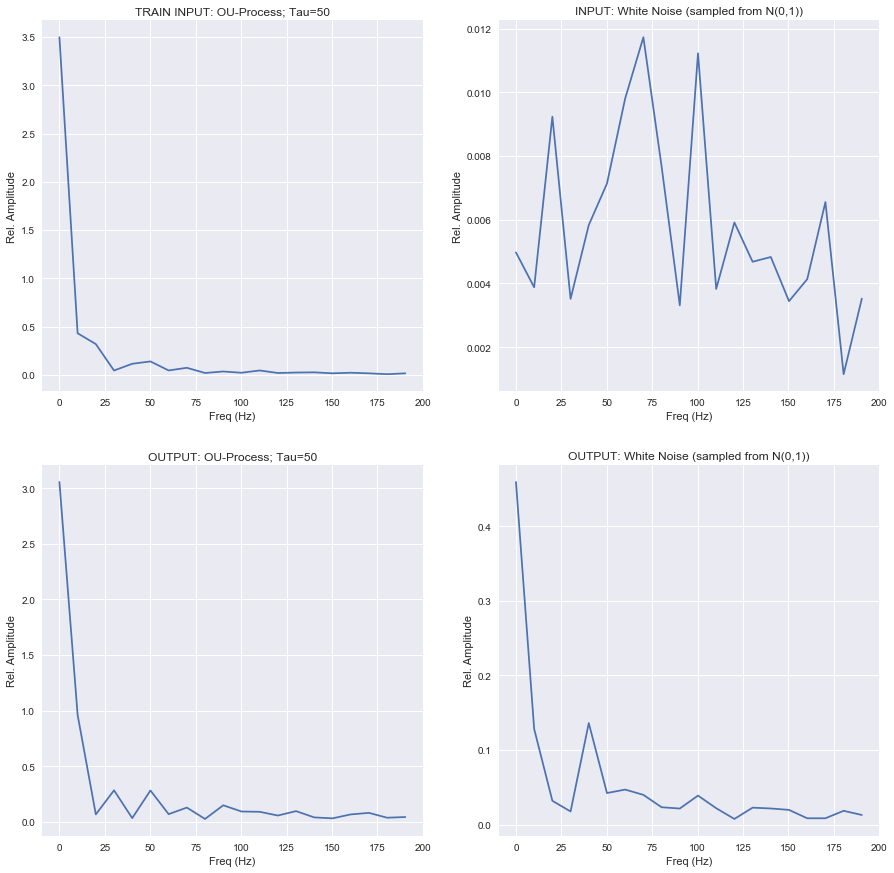

In [0]:
SAMPLE_LEN = 1000
dt_secs = dt / 1000.0
# fft_N = np.arange(0.0, SAMPLE_LEN, dt).shape[0]

i_inj_fft = scipy.fftpack.fft(i_inj[:SAMPLE_LEN, 0])
i_white_fft = scipy.fftpack.fft(i_white[:SAMPLE_LEN, 0])

ou_output_fft = scipy.fftpack.fft(out[:SAMPLE_LEN, 0])
white_output_fft = scipy.fftpack.fft(out_white[:SAMPLE_LEN, 0])

xf = np.linspace(0.0, 1.0/(2.0*dt_secs), SAMPLE_LEN/2)

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

FREQ_START = 0
FREQ_END = 20 # SAMPLE_LEN//2

axs[0, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_inj_fft[FREQ_START:FREQ_END]))
axs[0, 0].set_title('TRAIN INPUT: OU-Process; Tau=50')
axs[0, 0].set_xlabel('Freq (Hz)')
axs[0, 0].set_ylabel('Rel. Amplitude')
axs[1, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(ou_output_fft[FREQ_START:FREQ_END]))
axs[1, 0].title.set_text('OUTPUT: OU-Process; Tau=50')
axs[1, 0].set_xlabel('Freq (Hz)')
axs[1, 0].set_ylabel('Rel. Amplitude')

axs[0, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_white_fft[FREQ_START:FREQ_END]))
axs[0, 1].set_title('INPUT: White Noise (sampled from N(0,1))')
axs[0, 1].set_xlabel('Freq (Hz)')
axs[0, 1].set_ylabel('Rel. Amplitude')
axs[1, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(white_output_fft[FREQ_START:FREQ_END]))
axs[1, 1].set_title('OUTPUT: White Noise (sampled from N(0,1))')
axs[1, 1].set_xlabel('Freq (Hz)')
axs[1, 1].set_ylabel('Rel. Amplitude')

plt.show()
# plt.savefig('fft_ou_vs_white_full.png')

In [0]:
white_layer = Layer(NUM_NEURONS)
white_layer.train(i_inj=i_white, exp_output=i_white, dt=dt, t_stop=t_stop)
white_out, white_V, white_F_binary, white_F_synaptic = white_layer.output(i_inj, dt, t_stop)

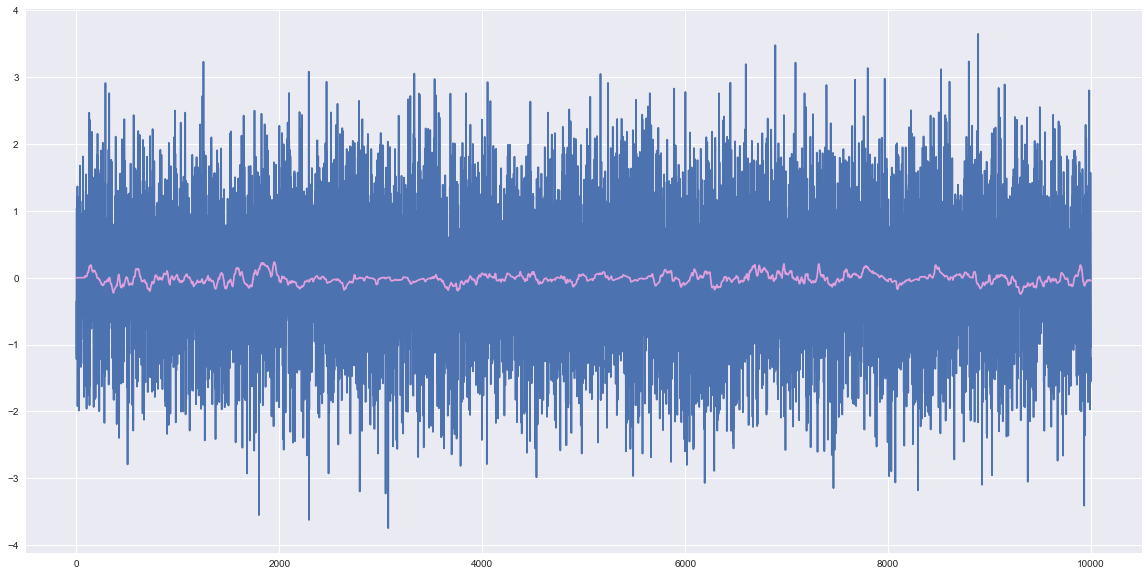

In [0]:
plt.figure(figsize=(20,10))
plt.plot(i_white[:10000])
plt.plot(white_out[:10000], 'plum')
plt.show()

In [0]:
ou_through_white, _, _, _ = white_layer.output(i_inj, dt, t_stop)

c:\program files\python35\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


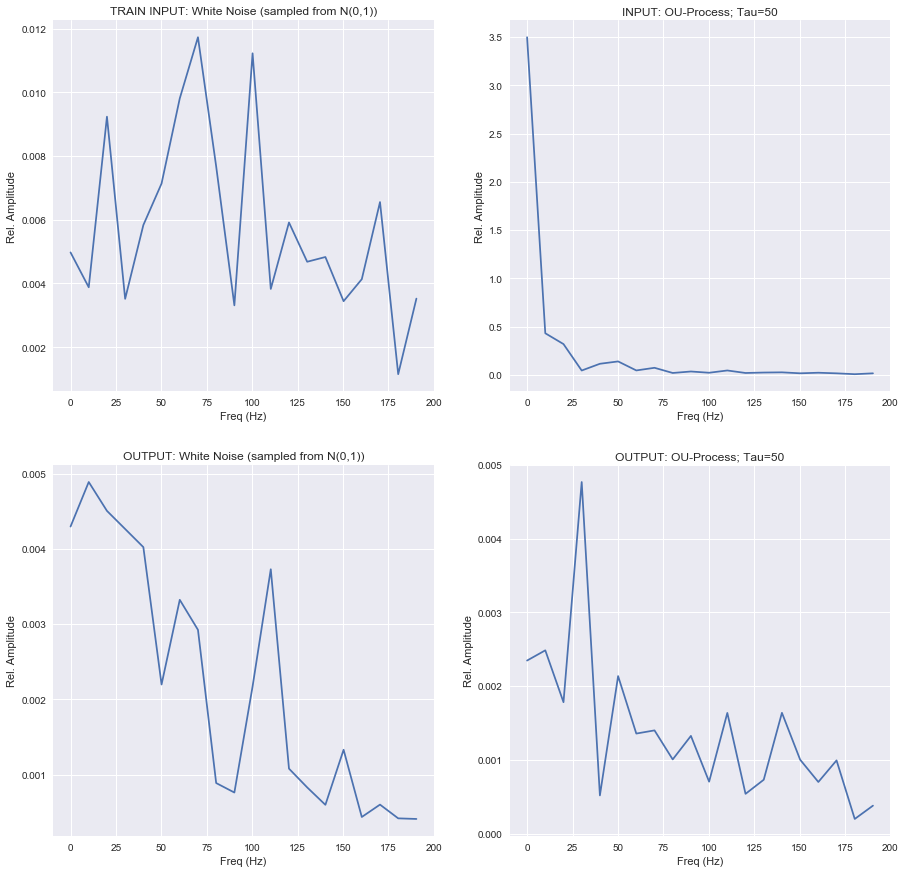

In [0]:
SAMPLE_LEN = 1000
dt_secs = dt / 1000.0
# fft_N = np.arange(0.0, SAMPLE_LEN, dt).shape[0]

i_inj_fft = scipy.fftpack.fft(i_inj[:SAMPLE_LEN, 0])
i_white_fft = scipy.fftpack.fft(i_white[:SAMPLE_LEN, 0])

ou_output_fft = scipy.fftpack.fft(ou_through_white[:SAMPLE_LEN, 0])
white_output_fft = scipy.fftpack.fft(white_out[:SAMPLE_LEN, 0])

xf = np.linspace(0.0, 1.0/(2.0*dt_secs), SAMPLE_LEN/2)

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

FREQ_START = 0
FREQ_END = 20 # SAMPLE_LEN//2

axs[0, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_white_fft[FREQ_START:FREQ_END]))
axs[0, 0].set_title('TRAIN INPUT: White Noise (sampled from N(0,1))')
axs[0, 0].set_xlabel('Freq (Hz)')
axs[0, 0].set_ylabel('Rel. Amplitude')
axs[1, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(white_output_fft[FREQ_START:FREQ_END]))
axs[1, 0].set_title('OUTPUT: White Noise (sampled from N(0,1))')
axs[1, 0].set_xlabel('Freq (Hz)')
axs[1, 0].set_ylabel('Rel. Amplitude')

axs[0, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_inj_fft[FREQ_START:FREQ_END]))
axs[0, 1].set_title('INPUT: OU-Process; Tau=50')
axs[0, 1].set_xlabel('Freq (Hz)')
axs[0, 1].set_ylabel('Rel. Amplitude')
axs[1, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(ou_output_fft[FREQ_START:FREQ_END]))
axs[1, 1].title.set_text('OUTPUT: OU-Process; Tau=50')
axs[1, 1].set_xlabel('Freq (Hz)')
axs[1, 1].set_ylabel('Rel. Amplitude')

plt.show()
# plt.savefig('fft_ou_vs_white_full.png')

### EXPERIMENT: How does amount of training data affect the weights?

In [0]:
import time

start_time = time.time()
loop_time = start_time

t_stop_var = 20.0e3

weights_v_training_t = []
training_ts = np.arange(1.0e3, 81.0e3, 10.0e3)

for t_stop_var in training_ts:
    # Slow Signal: INPUT
    input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop_var, 1)
    i_inj = 16.0 + 6.0*input_slow
    layer_var = Layer(NUM_NEURONS)
    layer_var.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop_var)
    
    weights_v_training_t += [layer_var.W]
    
    print("Training data length: ", t_stop_var)
    print("Iter time: ", time.time() - loop_time)
    print("Total time: ", time.time() - start_time)
    print("\n")
    loop_time = time.time()

Training data length:  1000.0
Iter time:  0.882685661315918
Total time:  0.882685661315918


Training data length:  11000.0
Iter time:  10.795552253723145
Total time:  11.678237915039062


Training data length:  21000.0
Iter time:  21.1056911945343
Total time:  32.783929109573364


Training data length:  31000.0
Iter time:  35.275272846221924
Total time:  68.05920195579529


Training data length:  41000.0
Iter time:  72.53712892532349
Total time:  140.9131302833557


Training data length:  51000.0
Iter time:  388.4214859008789
Total time:  529.653758764267


Training data length:  61000.0
Iter time:  615.6675934791565
Total time:  1146.6926057338715


Training data length:  71000.0
Iter time:  1406.828688621521
Total time:  2554.371639251709




In [0]:
np.savez(open(os.path.join(RESULTS_DIR, "exp__neurons=200__input=tau_50_same__t_stop=[1.0e3, 61.0e3, 10.0e3]_msecs.npz"), 'wb'),
            weights_v_training_t=weights_v_training_t,
            training_ts=training_ts
        )

In [0]:
exp_data = np.load(open(os.path.join(RESULTS_DIR, "exp__neurons=200__input=tau_50_same__t_stop=[1.0e3, 61.0e3, 10.0e3]_msecs.npz"), 'rb'))
weights_v_training_t = exp_data['weights_v_training_t'].tolist()
training_ts = exp_data['training_ts']

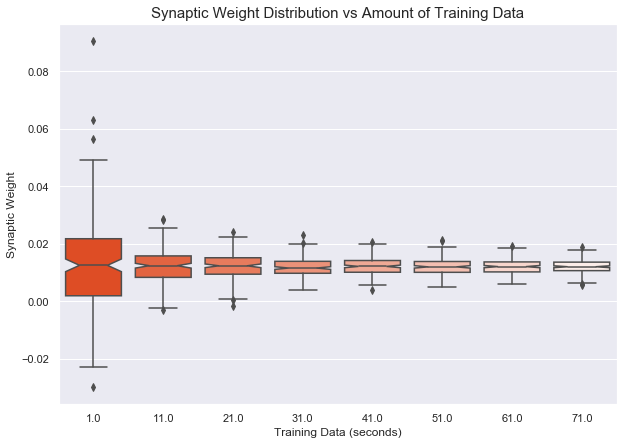

In [0]:
plt.figure(figsize=(10,7))

sns.boxplot(x=training_ts/1000.0, y=weights_v_training_t, notch=True, sym="o", palette=sns.light_palette("red orange", input="xkcd", reverse=True, n_colors=8))# palette="Paired")
plt.title('Synaptic Weight Distribution vs Amount of Training Data', fontsize=15)
plt.xlabel('Training Data (seconds)')
plt.ylabel('Synaptic Weight')

# plt.show()
plt.savefig("exp__neurons=200__input=tau_50_same__t_stop=[1.0e3, 61.0e3, 10.0e3]_msecs.png")